## Optimisation de portefeuille sous contrainte extra-financière

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

In [3]:
SDG = pd.read_excel('/Users/maximedumortier/Desktop/Mémoire/Datas/SDGs Coverage.xlsx')
SDG.set_index('TCUID', inplace=True)

In [4]:
SDG.head(3)

,Company Name,ISIN,Latest Year,Trucost Sector Revenue (USD mn),Trucost Sector Revenue Percentage (%),SDG Alignment\n(1 is Yes),SDG Revenue Alignment SDG 1 (%),SDG Revenue Alignment SDG 2 (%),SDG Revenue Alignment SDG 3 (%),SDG Revenue Alignment SDG 4 (%),...,SDG Risk Exposure SDG 14 (0-100),SDG Risk Exposure SDG 15 (0-100),SDG Risk Exposure SDG 16 (0-100),SDG Risk Exposure SDG 17 (0-100),SDG Risk Exposure All SDGs - All Value Chain\n(0-100),SDG Risk Exposure All SDGs - Direct\n(0-100),SDG Risk Exposure All SDGs - First Tier Indirect\n (0-100),Top Risk Exposure SDG - All Value Chain,Top Risk Exposure SDG - Direct,Top Risk Exposure SDG - First Tier Indirect
TCUID,,,,,,,,,,,,,,,,,,,,,
44276,Walmart Inc.,US9311421039,10090,500343.0,100.01,2,0.0,5.88,0.0,0.0,...,49.084462,36.148497,28.675886,52.579535,45.926881,46.142193,37.734325,10.1981,12.9645,12.0012
42752,China Petroleum & Chemical Corporation,CNE1000002Q2,10090,436987.1,100.01,0,0.0,0.00,0.0,0.0,...,53.153425,48.226218,45.335234,50.289929,57.773766,53.393833,55.049205,6.3505,6.3505,12.0012
48652,Royal Dutch Shell PLC,GB00B03MLX29,10090,388379.0,100.00,0,0.0,0.00,0.0,0.0,...,72.601465,66.536214,27.728193,51.811152,49.805512,43.029394,49.231189,13.1633,13.1628,12.0000


In [5]:
Price = pd.read_excel("/Users/maximedumortier/Desktop/Mémoire/Datas/BQL.xlsx")
Price = Price.iloc[:,:3500+1]
Price = Price.drop(Price.index[0])
Price = Price.set_index('Unnamed: 0')
Price = Price.astype(float)

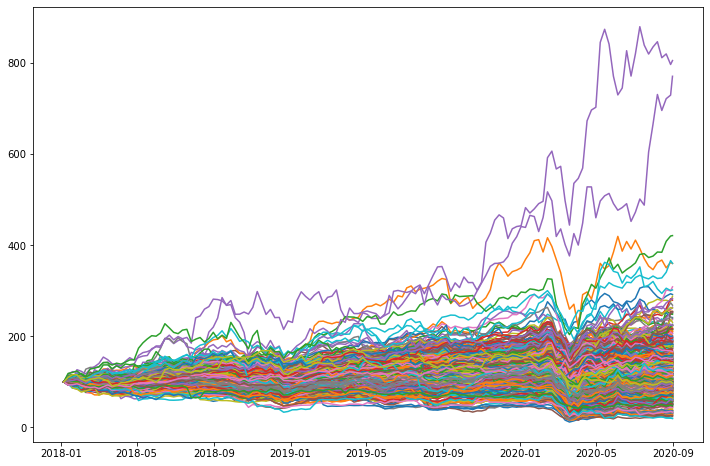

In [6]:
plt.figure(figsize=(12,8))
for col in Price.columns:
    plt.plot(Price[col]/Price[col].iloc[0]*100)
plt.show()

## Récupération des titres en commun dans nos données

In [7]:
Infos_Comp = pd.read_excel('/Users/maximedumortier/Desktop/Mémoire/Datas/Infos_Comp.xlsx')
Tickers_Isin_Dic = pd.Series(Infos_Comp.TICKER.values,index=Infos_Comp.ISIN).to_dict()

In [8]:
Tickers_Prices = Price.columns
Tickers_InfosComp = Infos_Comp.TICKER
Isin_SDG =  SDG['ISIN']
Tickers_Common = list(set(Tickers_Prices).intersection(Tickers_InfosComp))

In [9]:
len(Tickers_Common)
#len(Tickers_InfosComp)

489

In [10]:
if len(Tickers_Common) == len(Tickers_InfosComp):
    Isin_Common = pd.merge(Infos_Comp, SDG, on='ISIN')

In [11]:
W_SP500 = pd.DataFrame()
W_SP500['NAME'] = Isin_Common['NAME']
W_SP500['TICKER'] = Isin_Common['TICKER']
W_SP500['SDG13RevAl'] = Isin_Common['SDG Revenue Alignment SDG 13 (%)']
W_SP500['POIDS'] = Isin_Common['CUR_MKT_CAP']/Isin_Common['CUR_MKT_CAP'].sum()
W_SP500.POIDS.sum() #Poids des titres couverts par Trucost rebasés par la Market Cap au 18 septembre 2020
#W_SP500.sort_values(by="SDG13RevAl", ascending=False)

0.9999999999999999

## Arrangement des Prix pour aligner les colonnes avec notre série de titres disponibles

In [12]:
Price_Arrange = pd.DataFrame(index= Price.index)
for tick in W_SP500['TICKER']:
    Price_Arrange[tick] = Price[tick]
Correl_Mat = Price_Arrange.corr()

In [13]:
#Détermination de la matrice de corrélation entre les actifs
def matrice_variance_covariance(X):
    ax = sns.heatmap(X.corr(), vmin=0, vmax=1)
    return(ax)

<AxesSubplot:>

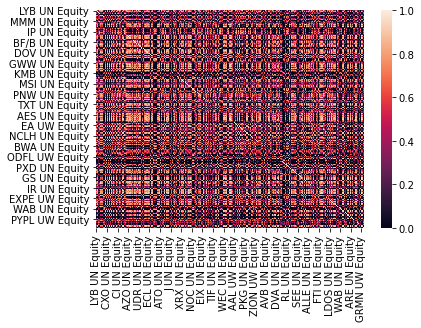

In [14]:
matrice_variance_covariance(Price_Arrange)

##  Optimisation sous contrainte d'alignement aux ODD

In [15]:
SDG_Align, Weight_SP500 = pd.DataFrame(), pd.DataFrame()
SDG_Align['SDG13RevAl'] = W_SP500['SDG13RevAl']
Weight_SP500['POIDS'] = W_SP500['POIDS']

In [16]:
SDG_Align.shape

(480, 1)

In [17]:
Weight_SP500.shape

(480, 1)

In [18]:
Correl_Mat.shape

(480, 480)

In [19]:
Weight_SP500.sort_values(by="POIDS",ascending=False).head(10).sum() #Les 10 premiers titres du SP 500

POIDS    0.298341
dtype: float64

In [20]:
SP500_Active_Return = Weight_SP500.T @ SDG_Align
SP500_Active_Return.iloc[0,0]

1.3531484981593764

In [21]:
weights = cp.Variable((480,1))
Active_Return = weights.T @ SDG_Align
Active_Risk = cp.quad_form((weights - Weight_SP500), Correl_Mat)
TE_ = 0.02
TE_Const = TE_**2
constraints = [sum(weights) == 1, TE_Const >= Active_Risk, weights >= 0, weights <= 0.05]
prob = cp.Problem(cp.Maximize(Active_Return), constraints)
result = prob.solve(qcp=True, verbose= False, solver= 'SCS', eps= 1e-10, max_iters = 100000, warm_start= True)

In [22]:
weights.value.sum()

0.9999999999349038

In [23]:
Active_Risk.value**0.5

array([[0.02]])

In [24]:
Active_Return.value[0,0]

19.302964451587652

In [25]:
df_results = W_SP500.copy()
df_results['POIDS OPTIM'] = weights.value

In [26]:
df_results_Main = df_results.loc[df_results['POIDS OPTIM'] > 0.01,:]
df_results_Main['POIDS OPTIM'].sum()

0.9547561206095937

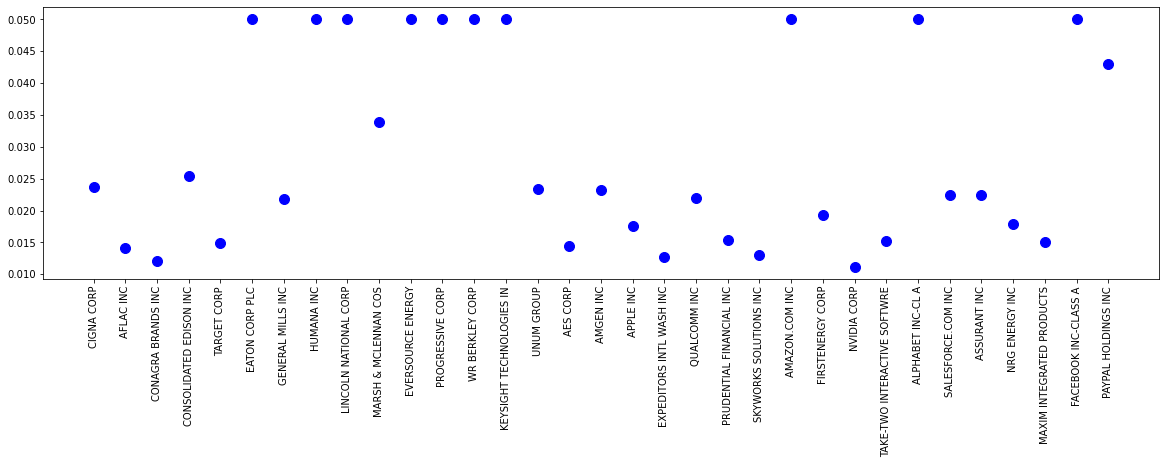

In [27]:
plt.figure(figsize=(20,5))
plt.plot(df_results_Main['NAME'],df_results_Main['POIDS OPTIM'], linestyle='none', marker='o', markersize=10,
        color='blue')
plt.xticks(rotation='vertical')
plt.show()

Trade Off TE vs Score ODD

In [28]:
TE_Range = [0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5]
TE_Score = []

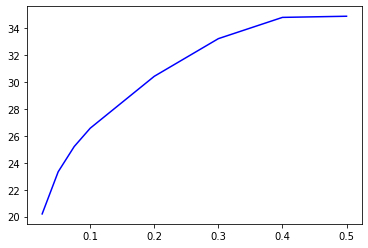

In [29]:
for TE_val in TE_Range:
    weights = cp.Variable((480,1))
    Active_Return = weights.T @ SDG_Align
    Active_Risk = cp.quad_form((weights - Weight_SP500), Correl_Mat)
    TE_ = TE_val
    TE_Const = TE_**2
    constraints = [sum(weights) == 1, TE_Const >= Active_Risk, weights >= 0, weights <= 0.05]
    prob = cp.Problem(cp.Maximize(Active_Return), constraints)
    result = prob.solve(qcp=True, verbose= False, solver= 'SCS', eps= 1e-10, max_iters = 100000, warm_start= True)
    TE_Score.append(Active_Return.value[0,0])
plt.plot(TE_Range, TE_Score, color='blue')

No handles with labels found to put in legend.


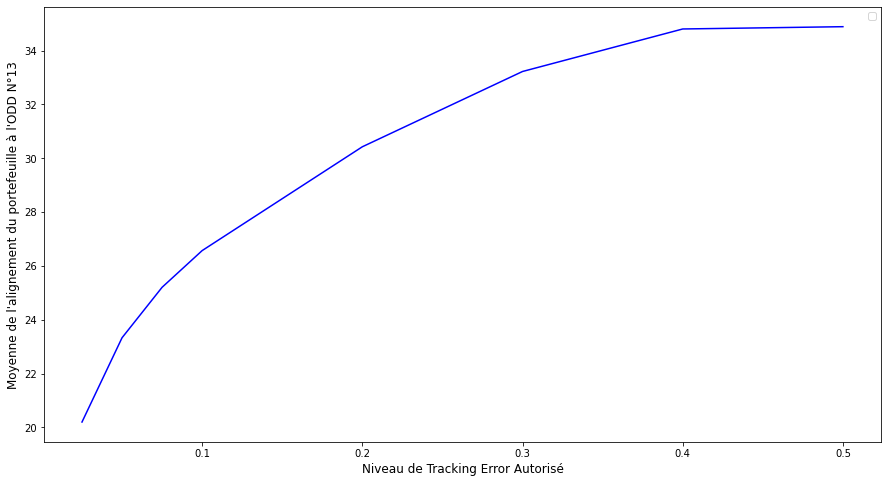

In [33]:
plt.figure(figsize=(15,8))
plt.plot(TE_Range, TE_Score, color='blue')
plt.xlabel('Niveau de Tracking Error Autorisé', fontsize=12)
plt.ylabel("Moyenne de l'alignement du portefeuille à l'ODD N°13", fontsize=12)
plt.legend()
plt.show()

## Optimisation sous contrainte ESG

In [35]:
ESG_Coverage = pd.read_excel('/Users/maximedumortier/Desktop/Mémoire/Datas/Amundi ESG World 20200825.xlsx')

In [36]:
ESG_Coverage['TICKER'] = ESG_Coverage['Ticker bloomberg'] + ' Equity'

In [37]:
Ticker_Common_ESG = pd.merge(Infos_Comp, ESG_Coverage, on='TICKER')

In [38]:
W_SP500_ESG = pd.DataFrame()
W_SP500_ESG['NAME'] = Ticker_Common_ESG['NAME']
W_SP500_ESG['TICKER'] = Ticker_Common_ESG['TICKER']
W_SP500_ESG['E_Score'] = Ticker_Common_ESG['E unbiased']
W_SP500_ESG['POIDS'] = Ticker_Common_ESG['CUR_MKT_CAP']/Ticker_Common_ESG['CUR_MKT_CAP'].sum()
W_SP500_ESG.POIDS.sum() #Poids des titres couverts par Trucost rebasés par la Market Cap au 18 septembre 2020
#W_SP500.sort_values(by="SDG13RevAl", ascending=False)

0.9999999999999999

In [39]:
Price_Arrange_ESG = pd.DataFrame(index= Price.index)
for tick in W_SP500_ESG['TICKER']:
    Price_Arrange_ESG[tick] = Price[tick]
Correl_Mat_ESG = Price_Arrange_ESG.corr()

In [40]:
Price_Arrange_ESG.shape

(140, 476)

<AxesSubplot:>

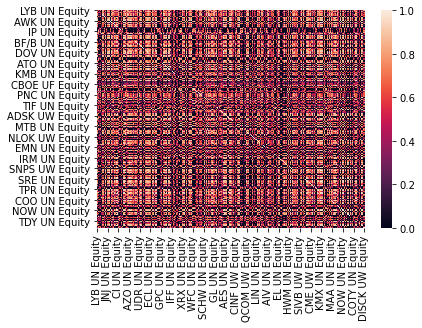

In [41]:
matrice_variance_covariance(Price_Arrange_ESG)

In [42]:
E_Score, Weight_SP500_ESG = pd.DataFrame(), pd.DataFrame()
E_Score['E_Score'] = W_SP500_ESG['E_Score']
Weight_SP500_ESG['POIDS'] = W_SP500_ESG['POIDS']
Weight_SP500_ESG.fillna(0, inplace=True)
E_Score.fillna(0, inplace=True)

In [43]:
SP500_Active_Return_ESG = Weight_SP500_ESG.T @ E_Score
SP500_Active_Return_ESG

,E_Score
POIDS,0.155123


In [65]:
weights_ESG = cp.Variable((476,1))
Active_Return_ESG = weights_ESG.T @ E_Score
Active_Risk_ESG = cp.quad_form((weights_ESG - Weight_SP500_ESG), Correl_Mat_ESG)

TE_ = 0.025
TE_Const = TE_**2
constraints_ESG = [sum(weights_ESG) == 1, TE_Const >= Active_Risk_ESG, weights_ESG >= 0, weights_ESG <= 0.05]
prob_ESG = cp.Problem(cp.Maximize(Active_Return_ESG), constraints_ESG)
result_ESG = prob_ESG.solve(qcp=True, verbose= False, solver= 'SCS', eps= 1e-10, max_iters = 100000, warm_start= True)

In [66]:
Active_Risk_ESG.value**0.5

array([[0.025]])

In [67]:
Active_Return_ESG.value

array([[1.54697909]])

In [68]:
df_results_ESG = W_SP500_ESG.copy()
df_results_ESG['POIDS OPTIM'] = weights_ESG.value

In [69]:
df_results_Main_ESG = df_results_ESG.loc[df_results_ESG['POIDS OPTIM'] > 0.01,:]
df_results_Main_ESG['POIDS OPTIM'].sum()

0.935181325294439

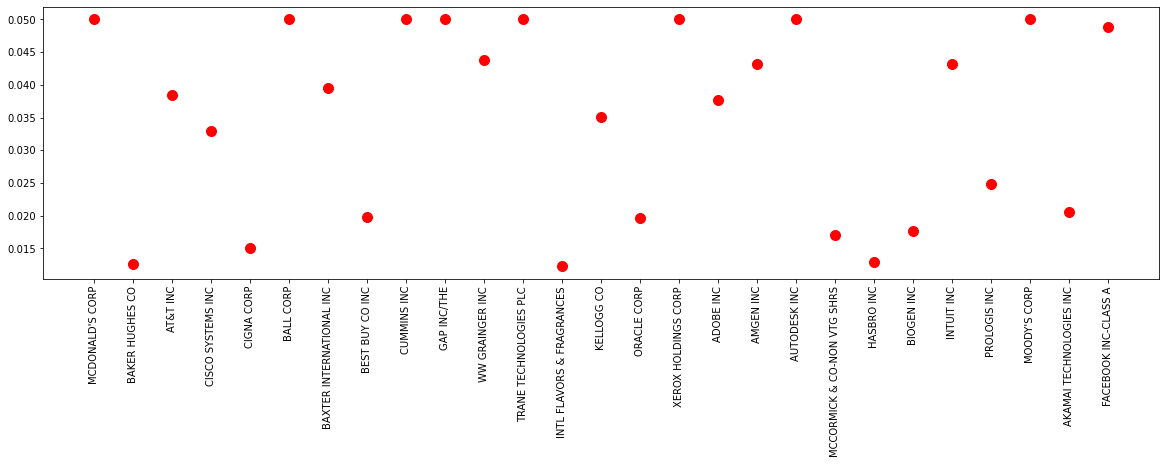

In [70]:
plt.figure(figsize=(20,5))
plt.plot(df_results_Main_ESG['NAME'],df_results_Main_ESG['POIDS OPTIM'], linestyle='none', marker='o', markersize=10,
        color='red')
plt.xticks(rotation='vertical')
plt.show()

Trade-Off Score E vs Tracking Error

In [71]:
TE_Range_ESG = [0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5]
TE_Score_ESG = []

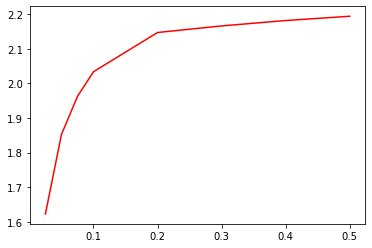

In [74]:
for TE_val in TE_Range_ESG:
    weights_ESG = cp.Variable((476,1))
    Active_Return_ESG = weights_ESG.T @ E_Score
    Active_Risk_ESG = cp.quad_form((weights_ESG - Weight_SP500_ESG), Correl_Mat_ESG)
    TE_ = TE_val
    TE_Const = TE_**2
    constraints_ESG = [sum(weights_ESG) == 1, TE_Const >= Active_Risk_ESG, weights_ESG >= 0, weights_ESG <= 0.2]
    prob_ESG = cp.Problem(cp.Maximize(Active_Return_ESG), constraints_ESG)
    result_ESG = prob_ESG.solve(qcp=True, verbose= False, solver= 'SCS', eps= 1e-10, max_iters = 100000, warm_start= True)
    TE_Score_ESG.append(Active_Return_ESG.value[0,0])
plt.plot(TE_Range_ESG, TE_Score_ESG, color='red')

No handles with labels found to put in legend.


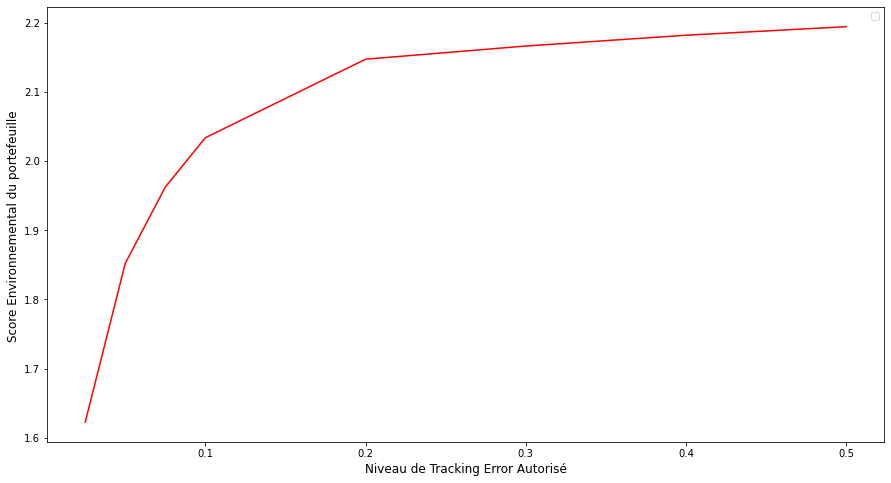

In [76]:
plt.figure(figsize=(15,8))
plt.plot(TE_Range_ESG, TE_Score_ESG, color='red')
plt.xlabel('Niveau de Tracking Error Autorisé', fontsize=12)
plt.ylabel("Score Environnemental du portefeuille ", fontsize=12)
plt.legend()
plt.show()

/Users/maximedumortier/opt/anaconda3/envs/cvxpy/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='E_Score', ylabel='Density'>

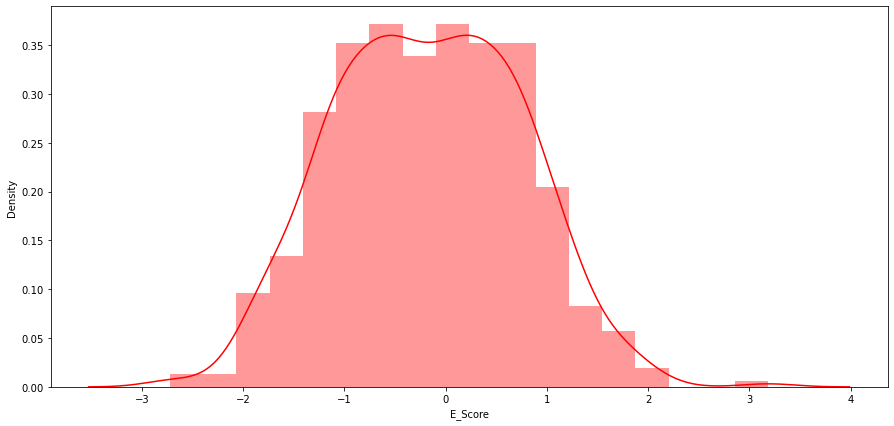

In [82]:
plt.figure(figsize=(15,7))
sns.distplot(W_SP500_ESG['E_Score'], color='red')

## Convergence des portefeuilles ?

In [88]:
temp = pd.merge(df_results, df_results_ESG, on='TICKER')
#x = ODD, y = ESG

In [91]:
temp['Poids Aggrégé'] = temp['POIDS OPTIM_x'] + temp['POIDS OPTIM_y']

In [97]:
temp_30 = temp.sort_values(by='Poids Aggrégé', ascending=False).head(30)

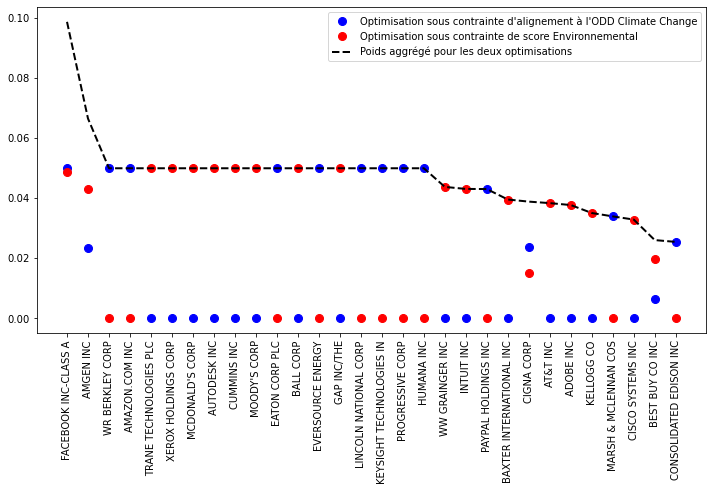

In [105]:
plt.figure(figsize=(12,6))
plt.plot(temp_30['NAME_x'], temp_30['POIDS OPTIM_x'], linestyle='none', marker='o', markersize=8,
         label="Optimisation sous contrainte d'alignement à l'ODD Climate Change", color='blue')
plt.plot(temp_30['NAME_x'], temp_30['POIDS OPTIM_y'], linestyle='none', marker='o', markersize=8, 
         label='Optimisation sous contrainte de score Environnemental', color='red')
plt.plot(temp_30['NAME_x'], temp_30['Poids Aggrégé'], lw=2, ls='--', c='black',
         label="Poids aggrégé pour les deux optimisations")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [106]:
temp_30['POIDS OPTIM_x'].sum()

0.6059020815111711

In [107]:
temp_30['POIDS OPTIM_y'].sum()

0.7975267754062315